In [1]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

training loss:0.1285, validation loss:0.1356: 100%|██████████| 500/500 [00:25<00:00, 19.92it/s]


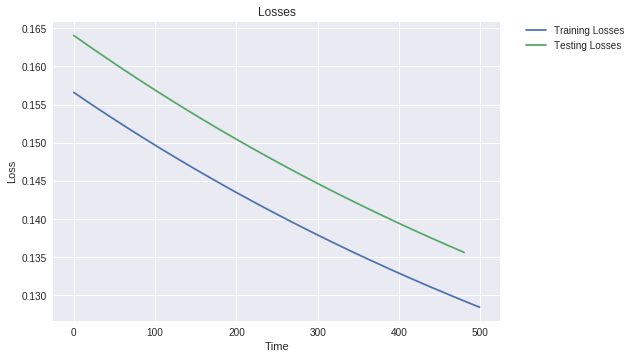

In [11]:
# Model class
class LinearNetwork(nn.Module):
  def __init__(self, data):
    super(LinearNetwork, self).__init__()                       # Init parent
    x, y = data[0]                                              # Get input and output from data
    c, h, w = x.size()                                          # Input size channels, height, width
    out = y.size(0)                                             # Ouput size
    
    self.net = nn.Sequential(nn.Linear(c * h * w, 100),        # Add steps to NN
                             nn.Sigmoid(),
                             nn.Linear(100, 100),
                             nn.Sigmoid(),
                             nn.Linear(100, out)
                            )        
    
  def forward(self, x):
    n, c, h, w = x.size()
    flattened = x.view(n, c * h * w)
    return self.net(flattened)                                  # Return batch of flattened images
  

# Data class
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root,                     # Imports dataset
                                      train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
    self.e = torch.eye(10)
    self.is_training = train
    
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, self.e[y].float()                                 # Puts output data into vector and returns with input
  
  def __len__(self):
    if self.is_training:                                        # Length of subset of data
      return 42
    else:
      return int(len(self.data) / 2)
  
# Init objects
EPOCHS = 500
  
data_train = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
data_test = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

model_train = LinearNetwork(data_train)                         # Init model
model_train = model_train.cuda()                                # Moves model to GPU

loader_train = DataLoader(data_train, 
                          batch_size=42,
                          pin_memory=True)

loader_test = DataLoader(data_test, 
                         batch_size=42,
                         pin_memory=True)

objective = torch.nn.MSELoss()                                  # Set loss function

optimizer = optim.SGD(model_train.parameters(), lr=1e-4)        # Optimize our wieghts and biases at learning rate

losses_train = []
losses_test = []

epochs_train = []
epochs_test = []

# Start training
loop = tqdm(total=EPOCHS, position=0)

for epoch in range(EPOCHS):
  
  # Train batch
  total_loss = 0
  for x, y_truth in loader_train:                               # Train model
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)   # Move batch to GPU
    optimizer.zero_grad()
    
    y_hat = model_train(x)
    
    loss = objective(y_hat, y_truth)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()
  losses_train.append(total_loss / len(loader_train))
  epochs_train.append(epoch)
    
  # Test
  if epoch % 20 == 0:
    total_loss = 0
    for x, y_truth in loader_test:                                # Test model
      x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)   

      y_hat = model_train(x)

      loss = objective(y_hat, y_truth)
      total_loss += loss.item()
      
    losses_test.append(total_loss / len(loader_test))
    epochs_test.append(epoch)
    
  loop.set_description('training loss:{:.4f}, validation loss:{:.4f}'.format(losses_train[-1], losses_test[-1]))
  loop.update(1)
    
loop.close()

# Plot results
plt.plot(epochs_train, losses_train, label="Training Losses")
plt.plot(epochs_test, losses_test, label="Testing Losses")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Losses")
plt.xlabel("Time")
plt.ylabel("Loss")

plt.show()
  